**Tolman-Oppenheimer-Volkoff equation solver. MIT bag model.**

The TOV equations are given by following formula:
\begin{equation}
\frac{dp}{dr}=-G\left(\rho\left(1+\frac{\epsilon}{c^2}\right)+\frac{p}{c^2}\right)\frac{m+4\pi r^3p/c^2}{r(r-2Gm/c^2)} \tag{1}
\end{equation}
\begin{equation}
\frac{dm}{dr}=4\pi r^2 \rho(1+\epsilon/c^2) \tag{2}
\end{equation}
\begin{equation}
\frac{d\phi}{dr}=\frac{m+4\pi r^3p/c^2}{r(r-2Gm/c^2)} \tag{3}
\end{equation}

Now this equations are becomes closed when we specify pressure-density dependence. We took two models into accont polytropic equation of state and MIT bag model:

$$p=\frac{\rho c^2 - 4 B}{3} \tag{4}$$

First let us write down all the coefficients that will be used in calculations. CGS units were used.

**Define the bag constant that is going to be used in whole program**. To do that use *bag_const_def* function. By choosing bag constant you also define the minimum value for the central density, otherwise pressure could become negative:

$$\rho c^2 - 4 B>0$$


In [0]:
import numpy as np
import matplotlib.pyplot as plt

ggrav = 6.673E-8
clite = 2.99792458E10
g_c2 = ggrav/clite**2
msun = 1.98892E33
minpress=1E-3

#makes conversion between Mev/fm^3 and SI units
#and defines min possible density so that pressure
#does not become negative
#it is in cgs units
def bag_const_def(b_const):
  conversed_b = b_const*1.602176E33
  min_rho = 4*conversed_b/clite**2
  return conversed_b,round(min_rho/1.0E14)
#bag const!!
Beos,rho_min=bag_const_def(60)

In [0]:
def poly_const_def(gamma_):
  k_guess=1.98183E-6
  rho_guess=2E14
  press_guess=k_guess*(rho_guess)**2.75
  k = press_guess/(rho_guess)**gamma_ #poly const for particular gamma
  return k

In [0]:
gamma=2.5
k_poly=poly_const_def(gamma)
k_poly=round(k_poly,9)


Now let us define number of zones (we devide star for small integration zones) and maximum allowed radius:

In [0]:
nzones = 4000 #number of zones 
rmax  = 1.5E6 # 15 km
dr = rmax/(nzones-1) #xstep 

We use *feval* to pass function names into functions. This will be clear later on.

In [0]:
def feval(funcName, *args): 
    return eval(funcName)(*args)

In the next cell, we define all the functions that are going to be used to calculate thermodynamic properties of the star. *Reveos* means reversed EOS to calculate density when pressure value is given. The need for this function could be seen from PDEs given above. As you can see only pressure and gravitational mass are calculated at each subsequent step *$r_i$+dr*, but not density (cause press and mass derivative given only). To calculate density at step *$r_i$+dr*, we have to use EOS with pressure value at this step. 

Torsion case special in this case because there is no analytic expression to define density from pressure value. That is why we use Newton-Raphson algorithm.

In [0]:
#mit bag model eos
def eos_mit(rho_):
  return (rho_*clite**2-4*Beos)/3

#reversed eos to define value of density
def reveos_mit(press_,*args): 
  press_=max(minpress,press_)
  rho_= (3*press_+4*Beos)/clite**2 
  return rho_
#newton-raphson algorithm to define density value from pressure
def reveos_torsion_mit(pressi_,rho_crit):
  pts=50
  tp=np.zeros(pts)
  tp[0]=1E15 #initial guess
  ii=1
  while abs(tp[ii-1]-tp[ii])/1E14>1E-8: #for ii in range(pts-1):
    if ii==pts-1:
      break
    else:
      te =  rho_crit/2*(1-(1-4*tp[ii]/rho_crit)**0.5) #temporary variable to ease calculations
      eqn = (te*clite**2-4*Beos)/3 - (clite*tp[ii])**2/rho_crit-pressi_ #equation as it is 
      deqn = clite**2*(1 - 2/(3*(1 - 4*tp[ii]/rho_crit)**0.5)) #derivative of the equation
      tp[ii+1]=tp[ii] - eqn/deqn #Newton-Raphson formula
      rho_eff=tp[ii+1]
    ii=ii+1
  return rho_eff 
  

def semi(rho_cent,rho_crit): #semiclassical corrections
  return rho_cent - rho_cent**2/rho_crit

def torsion(rho_cent,press_,rho_crit): #Torsional corrections
  temprho = rho_cent - rho_cent**2/rho_crit
  tempress = press_ - clite**2*rho_cent**2/rho_crit
  return tempress

In [0]:
def eos_poly(rho_):
  return k_poly*rho_**gamma

def reveos_poly(press_,*args): 
  press_=max(minpress,press_)
  rho_= (press_/k_poly)**(1/gamma) 
  return rho_
#newton-raphson algorithm to define density value from pressure
def reveos_torsion_poly(pressi_,rho_crit):
  pts=50
  tp=np.zeros(pts)
  tp[0]=1E15 #initial guess
  ii=1
  while abs(tp[ii-1]-tp[ii])/tp[0]>1E-8: #for ii in range(pts-1):
    if ii==pts-1:
      break
    else:
      te =  (1-4*tp[ii]/rho_crit)**0.5 
      tm =  rho_crit/2*(1-te)
      h = 0.2973017*gamma*k_poly
      eqn = k_poly*tm**gamma - (clite*tm)**2/rho_crit-pressi_
      deqn = (h*(2.0*tm)**(gamma-1) - 2.0*tm*clite**2/rho_crit)/te
      tp[ii+1]=tp[ii] - eqn/deqn
      rho_eff=tp[ii+1]
    ii=ii+1
  return rho_eff 

Now we define RHS of PDEs. It was divided to *classical* and *modified* as they are different from each other. In the classical case equations (1) - (3) were used as they are given, while in modified case 
$$\frac{dp_{eff}}{dr}=f(p_{eff},m_{eff},\rho_{eff}) \tag{5}$$
$$\frac{dm_{eff}}{dr}=g(\rho_{eff}) \tag{6}$$
$$\frac{dm}{dr}=g(\rho) \tag{7}$$ 
additional mass derivative passed to integration algorigthm (*f* and *g* are given by equation (1) and (2) respectively). This is done in order to determine physical gravitational mass of the star. The reason is that for calculating the object’s mass in the semi-classical case, one has to use equation (7) with the physical density ρ while the boundary radius Rb is obtained from integration of the effective eTOV (5), (6) equation.

In [0]:
def RHS_cl(p_and_m,r_,*args):  #RHS of PDE
  press_=p_and_m[0]
  mgrav_=p_and_m[1]
  model =args[1]
  if model=='reveos_poly':
    rho_=feval(model,press_)
    eps = press_/(gamma - 1.0)/rho_
    mu  = rho_ + rho_*eps/clite**2
  elif model=='reveos_mit':
    mu  =feval(model,press_)

  a=ggrav*(mu+press_/clite**2)*(mgrav_+4*np.pi*(r_**3)*press_/clite**2)/(r_*(2*g_c2*mgrav_-r_)) #dp/dr
  b=4*np.pi*(r_**2)*mu #dm/dr
  y=[]
  y.append(a)
  y.append(b)
  return y

def RHS_modified(p_and_m,r_,*args):  #RHS of PDE of modified
  press_e_=p_and_m[0] 
  mgrav_=p_and_m[1]
  mgrav_e_=p_and_m[2]
  rho_crit=args[0]
  reveos_func=args[1] #the name of function use to calculate density
                      #it could be either (reveos_mit) or
                      #(reveos_torsion)
  
  rho_e_=feval(reveos_func,press_e_,rho_crit) #calc eff density
  rho_ = rho_crit/2*(1-(1-4*rho_e_/rho_crit)**0.5) #calc physical density from eff density
  press_ = feval('eos_poly',rho_)
  eps = press_/(gamma-1.0)/rho_
  mu_e = rho_e_+rho_e_*eps/clite**2
  mu = rho_ + rho_*eps/clite**2
  if reveos_func=='reveos_poly':
    rho_e_=mu_e
    rho_ = mu
  a=ggrav*(rho_e_+press_e_/clite**2)*(mgrav_e_+4*np.pi*(r_**3)*press_e_/clite**2)/(r_*(2*g_c2*mgrav_e_-r_)) #dp_eff/dr
  b=4*np.pi*(r_**2)*rho_ #dm_eff/dr
  c=4*np.pi*(r_**2)*rho_e_ #dm_phys/dr
  y=[]
  y.append(a)
  y.append(b)
  y.append(c)
  return y

Now define global variables that are used to calculate thermodynamic properties at each integration step.

In [0]:
#allocate parameters used in integration  
mgrav=np.zeros(nzones)
press=np.zeros(nzones)
rho=np.zeros(nzones)
rs=np.zeros(nzones)
mgrav_e=np.zeros(nzones)
press_e=np.zeros(nzones)


#values of radius
rs[0]=0.01
for i in range(1,nzones):
  rs[i]=rs[i-1]+dr

[Runge–Kutta–Fehlberg](https://https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method) method was used to calculate mass and pressure at each subsequent step.

In [0]:
def RKF45(RHS_func,invar,step,*args):
  x=step
  num=len(invar)
  tmp_dat=np.zeros(num)
  sol=np.zeros(num)
  rho_crit=args[0]
  reveos_func=args[1]
  
  k1 = feval(RHS_func,invar,x,rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] + k1[i]*(dr/5)
  
  k2 = feval(RHS_func,tmp_dat,x+dr/5,rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] + k1[i]*(3*dr/40) + k2[i]*(9*dr/40)
  
  k3 = feval(RHS_func,tmp_dat,x+(3*dr/10),rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] + k1[i]*(3*dr/10) - k2[i]*(9*dr/10) + k3[i]*(6*dr/5)

  k4 = feval(RHS_func,tmp_dat,x+(3*dr/5),rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] - k1[i]*(11*dr/54) + k2[i]*(5*dr/2) - k3[i]*(70*dr/27) + k4[i]*(35*dr/27)

  k5 = feval(RHS_func,tmp_dat, x+dr,rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] + k1[i]*(1631*dr/55296) + k2[i]*(175*dr/512) + k3[i]*(575*dr/13824) + k4[i]*(44275*dr/110592) + k5[i]*(253*dr/4096)
    
  k6 = feval(RHS_func,tmp_dat,x+(7*dr/8),rho_crit,reveos_func)

  for j in range(num):
    sol[j] = invar[j] + dr*(37*k1[j]/378 + 250*k3[j]/621 + 125*k4[j]/594 + 512*k6[j]/1771)
     
  return  sol #press and mgrav

Number of central densities used to calculate $M-R_b$ plot

In [0]:
n=100 #central initial densities

Classical TOV solver. Equations (1), (2) used as they are. 

1st loop here is used to sweep through central densities which are given by *rho_cit*.  So *rho_cit[i]* sets central density and initial values of mass and pressure are calculated through EOS.

Then 2nd loop sweep through all the integration zones. *tempvar* variable is used to pass previous pressure and mass values to RKF45 algorithm and calculte current pressure and mass values. Then *while* function is used to define the point where pressure becomes negative stating the point of boundary of the star. After that boundary radius and mass for given *rho_cit* are stored in *rb* and *M* arrays respectively.




In [0]:
def TOV_cl(n_cden,model):
  num_of_var=2
  rho_cit=np.zeros(n_cden)
  rb = np.zeros(n_cden)
  M = np.zeros(n_cden)
  tempvar=np.zeros(num_of_var)
  
  temppress=np.zeros((n_cden,nzones))
  for i in range(n_cden): #1st loop
    if model=='poly':
      rho_cit[i]=0.5E14+i*0.25E14
    elif model=='mit':
      rho_cit[i]=rho_min*1.0E14 + (i+2)*0.25E14

  #initial values

    rho[0]=rho_cit[i]
    press[0]=feval('eos_{}'.format(model),rho[0])  
    mgrav[0]=(4*np.pi*rho[0]*rs[0]**3)/3.0


    for j in range(1,nzones): #2nd loop
      tempvar[0]=max(press[j-1],minpress)
      tempvar[1]=mgrav[j-1]
      press[j],mgrav[j]=RKF45('RHS_cl',tempvar,rs[j-1],1,'reveos_{}'.format(model)) #here rho_crit and reveos_func taken as 1
                                                      #do not delete them, cause RKF45 requires them to be passed
                                                            #they are not used in classical case 
      #rho[j] = reveos_mit(press[j])
    
    k=0
    while press[k]>0:
      k=k+1
      isurf=k-1 
    rb[i]=rs[isurf]/1E5
    M[i]=mgrav[isurf]/msun
    temppress[i,:]=press
  return rb,M,temppress#,mgrav,rho 


Modified TOV solver. Semiclassical correction to EOS was used. 

It almost the same as in classical case, with difference in the 1st loop. 1st loop is used to calculate critical densities, that are on turn is used to define effective pressure and mass. 

Critical density values in this case: 1.5E16, 4E16, 1E17

In [0]:
def TOV_semi(n_cden,model):
  num_of_var=3
  num_of_crden=3 #number of critical densities
  tempvar=np.zeros(num_of_var)
  M=np.zeros((num_of_crden,n_cden))
  rb=np.zeros((num_of_crden,n_cden))
  rho_cr=np.zeros(num_of_crden)
  rho_cit=np.zeros(n_cden)
  
  temppress=np.zeros((num_of_crden,n_cden,nzones))
  #tempmass=np.zeros((num_of_crden,n_cden,nzones))
  #temprho=np.zeros((num_of_crden,n_cden))
  for g in range(1,4):
    rho_cr[g-1]=(1.75*g**2-2.75*g+2.5)*1.0E16
    for i in range(n_cden):
      if model=='poly':
        rho_cit[i] =0.5E14+i*0.25E14#
      elif model=='mit':
        rho_cit[i]=rho_min*1.0E14 + (i+2)*0.25E14#
  
      #initial values
      rho[0]=semi(rho_cit[i],rho_cr[g-1]) #effective rho
      #physical and effective masses
      mgrav[0]=(4*np.pi*rho_cit[i]*rs[0]**3)/3.0
      mgrav_e[0]=(4*np.pi*rho[0]*rs[0]**3)/3.0
      #physical and effective pressure 
      press[0]=feval('eos_{}'.format(model),rho_cit[i])
      press_e[0]=feval('eos_{}'.format(model),rho[0])
      
      
      
      for j in range(1,nzones):
        tempvar[0]=max(press_e[j-1],minpress)
        tempvar[1]=mgrav[j-1]
        tempvar[2]=mgrav_e[j-1]
        press_e[j],mgrav[j],mgrav_e[j]=RKF45('RHS_modified',tempvar,rs[j-1],rho_cr[g-1],'reveos_{}'.format(model))
        #rho[j] = reveos_mit(press[j])
      k=0
      while press_e[k]>0:
        k=k+1
        isurf1=k-1
      rb[g-1,i]=rs[isurf1]/1E5
      M[g-1,i]=mgrav[isurf1]/msun
      temppress[g-1,i,:]=press_e
      #tempmass[g-1,i,:]=mgrav
      #temprho[g-1,i,:]=rho
  return rb,M,temppress#,tempmass,temprho  

Modified TOV solver. Torsional correction to EOS was used. 

It almost the same as in classical case, with difference in the 1st loop. 1st loop is used to calculate critical densities, that are on turn is used to define effective pressure and mass. 

Critical density values in this case: 1E17, 2.5E17, 5E17

In [0]:
def crit_dens_mit(nn):
  return (0.5*nn**2+0.5)*1.0E17
def crit_dens_poly(nn):
  return (nn**2-nn+2)*1.0E17


def TOV_torsion(n_cden,model):
  num_of_var=3
  num_of_crden=3
  tempvar=np.zeros(num_of_var)
  M=np.zeros((3,n_cden))
  rb=np.zeros((3,n_cden))
  rho_cr=np.zeros(3)
  rho_cit=np.zeros(n_cden)
  
  temppress=np.zeros((num_of_crden,n_cden,nzones))
  #tem]pmass=np.zeros((num_of_crden,n_cden,nzones))
  #temprho=np.zeros((num_of_crden,n_cden))  
  
  for g in range(1,4):
    rho_cr[g-1]=feval('crit_dens_{}'.format(model),g)
    for i in range(n):
      if model=='poly':
        rho_cit[i] =0.5E14+i*0.25E14
        
      elif model=='mit':
        rho_cit[i] =rho_min*1.0E14+(i+2)*0.25E14
      #initial values
      rho[0]=semi(rho_cit[i],rho_cr[g-1])
      
      mgrav[0]=(4*np.pi*rho_cit[i]*rs[0]**3)/3.0
      mgrav_e[0]=(4*np.pi*rho[0]*rs[0]**3)/3.0
      
      press[0]=feval('eos_{}'.format(model),rho_cit[i])
      press_e[0]=torsion(rho_cit[i],press[0],rho_cr[g-1])
      
    
      for j in range(1,nzones):
        tempvar[0]=max(press_e[j-1],minpress)
        tempvar[1]=mgrav[j-1]
        tempvar[2]=mgrav_e[j-1]
        press_e[j],mgrav[j],mgrav_e[j]=RKF45('RHS_modified',tempvar,rs[j-1],rho_cr[g-1],'reveos_torsion_{}'.format(model))
        #rho[j] = reveos_torsion(press[j])
      k=0
      while press_e[k]>0:
        k=k+1
        isurf=k-1
      rb[g-1,i]=rs[isurf]/1E5
      M[g-1,i]=mgrav[isurf]/msun
      temppress[g-1,i,:]=press_e
      #tempmass[g-1,i,:]=mgrav
      #temprho[g-1,i,:]=rho
  return rb,M,temppress  

The final step is to use solvers to calculate all parameters.

In [0]:
rb_cl_mit,M_cl_mit,p_cl_mit=TOV_cl(n,'mit') #,p_cl

In [0]:
rb_semi_mit,M_semi_mit,p_semi_mit=TOV_semi(n,'mit')

KeyboardInterrupt: ignored

In [0]:
rb_tor_mit,M_tor_mit,p_tor_mit=TOV_torsion(n,'mit')

Here we plot *M - R* relation for semiclassical corrections to TOV.

In [0]:
plt.plot(rb_cl_mit,M_cl_mit,'k',lw=0.7)
lines=['--',':','-.']
for i in range(3):
  plt.plot(rb_semi_mit[i],M_semi_mit[i],lines[i],c='k',lw=1.3)
plt.rcParams['figure.figsize'] = [18, 13]
plt.show()

In [0]:
cen_dens=48 #1.65E15

bound_cl=np.where(rs/1E5 == rb_cl_mit[cen_dens])
boundary=int(bound_cl[0])
bry_semi=np.zeros(3,dtype=int)
for i in range(3):
  b_semi=np.where(rs/1E5 == rb_semi_mit[i,cen_dens])
  bry_semi[i]=int(b_semi[0])

  

plt.plot(rs[0:boundary]/1E5,p_cl_mit[cen_dens,0:boundary]/p_cl_mit[cen_dens,0],'k',lw=1.2)
for i in range(3):
  plt.plot(rs[0:bry_semi[i]]/1E5,p_semi_mit[i,cen_dens,0:bry_semi[i]]/p_cl_mit[cen_dens,0],
           lines[i],c='k',lw=1.2)
#plt.plot()
plt.show()

In [0]:
plt.plot(rb_cl_mit,M_cl_mit,'k',lw=0.7)
for i in range(3):
  plt.plot(rb_tor_mit[i],M_tor_mit[i],lines[i],c='k',lw=1.3)
plt.rcParams['figure.figsize'] = [18, 13]
plt.show()

In [0]:
print(round(4.2714514,3))

Polytropic equation of state. 

---


$$p=K \rho^{\gamma} \tag{4}$$

Now let's solve case for polytropi EOS. The whole procedure is the same with difference in minor parts. 

Fisrt let us define relation betweeen polytropic constant $K$ and power of polytrope $\gamma$. For that we fix the initial value of central density and pressure and calculate constant for different values of $\gamma$. Initial guess for $K=1.98183\cdot10^{-6}$ is taken from C. Ott tutorial paper.


Now lets define EOS and reversed EOS for polytropic case.

In [0]:
rb_cl_poly,M_cl_poly,p_cl_poly=TOV_cl(n,'poly')

In [0]:
rb_semi_poly,M_semi_poly,p_semi_poly=TOV_semi(n,'poly')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


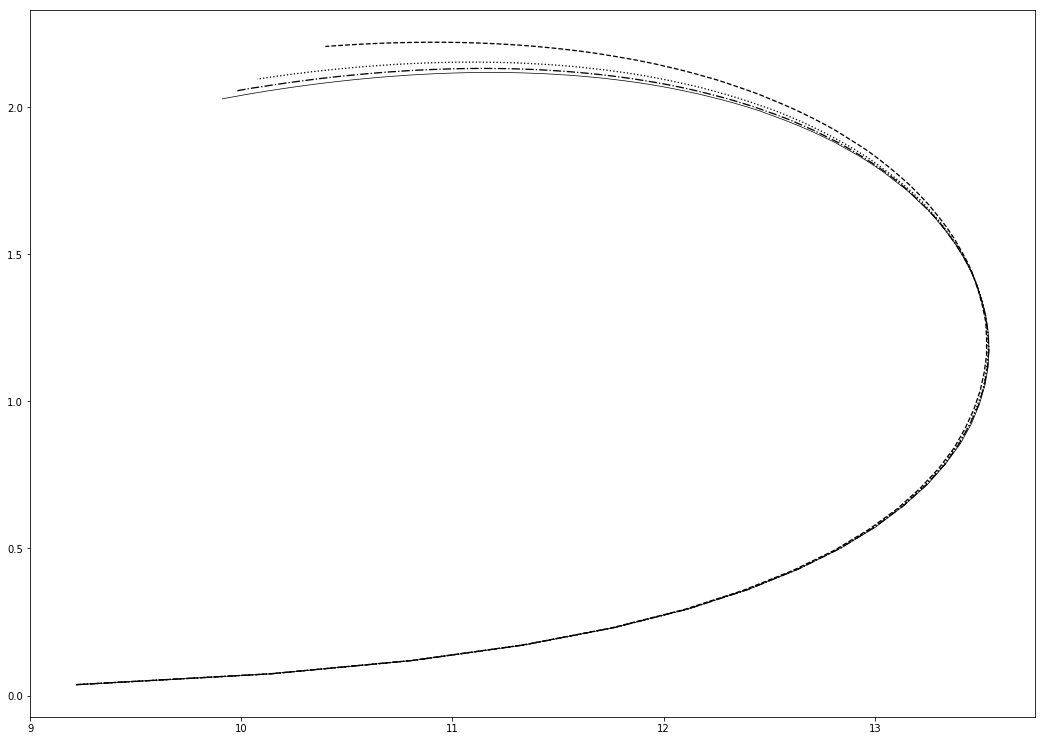

In [0]:
plt.plot(rb_cl_poly,M_cl_poly,'k',lw=0.7)
lines=['--',':','-.']
for i in range(3):
  plt.plot(rb_semi_poly[i],M_semi_poly[i],lines[i],c='k',lw=1.3)
plt.rcParams['figure.figsize'] = [18, 13]
plt.show()

In [0]:
rb_tor_poly,M_tor_poly,p_tor_poly=TOV_torsion(n,'poly')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


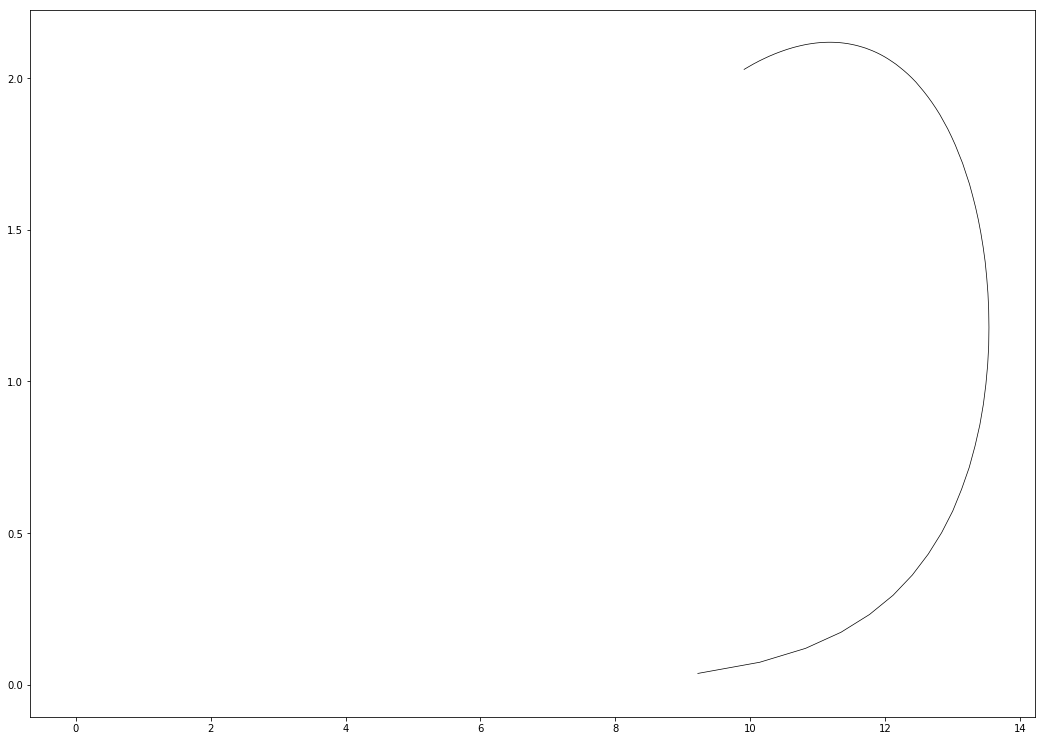

In [0]:
plt.plot(rb_cl_poly,M_cl_poly,'k',lw=0.7)
lines=['--',':','-.']
for i in range(3):
  plt.plot(rb_tor_poly[i],M_tor_poly[i],lines[i],c='k',lw=1.3)
plt.rcParams['figure.figsize'] = [18, 13]
plt.show()